In [7]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
np.random.seed(1234)

# Generate a test signal (a 2 Vrms) sine wave at 1000 Hz and a second one a 1500 Hz, corrupted by 
# 0.001 V**2/Hz of white noise sampled at 7.5 kHz

fs = 7.5e3
N = 500
amp = 2*np.sqrt(2)
freq=1000
noise_power = 0.001 * fs /2
time = np.arange(N) / fs
data = amp* np.sin(2*np.pi*freq*time) + 0.7*amp* np.sin(2*np.pi*1.5*freq*time)
data += np.random.normal(scale=np.sqrt(noise_power),size=time.shape)

# Welch estimate parameters
segment_size = np.int32(0.5*N) # Segment size = 50 % of data length
overlap_fac = 0.5
overlap_size = overlap_fac*segment_size
fft_size = 512
detrend = True # If true, removes signal mean
scale_by_freq = True

# Frequency resolution
fres = fs/segment_size

## Welch function
f, PSD_welch = signal.welch(data, fs,window='hann', nperseg=segment_size,noverlap=overlap_size,nfft=fft_size,return_onesided=True,detrend='constant', average='median')


## Own implementation
# PSD size = N/2 + 1 
PSD_size = np.int32(fft_size/2)+1


# Number of segments
baseSegment_number = np.int32(len(data)/segment_size) # Number of initial segments
total_segments =  np.int32(baseSegment_number + ((1-overlap_fac)**(-1) - 1 ) * (baseSegment_number - 1)) # No. segments including overlap
window = signal.hann(segment_size) # Hann window

if scale_by_freq:
    # Scale the spectrum by the norm of the window to compensate for
    # windowing loss; see Bendat & Piersol Sec 11.5.2.
    S2 = np.sum((window)**2) 
else:
    # In this case, preserve power in the segment, not amplitude
    S2 = (np.sum(window))**2

fft_segment = np.empty((total_segments,fft_size),dtype=np.complex64)
for i in range(total_segments):
    offset_segment = np.int32(i* (1-overlap_fac)*segment_size)
    current_segment = data[offset_segment:offset_segment+segment_size]
    # Detrend (Remove mean value)   
    if detrend :
        current_segment = current_segment - np.mean(current_segment)
    windowed_segment = np.multiply(current_segment,window)
    fft_segment[i] = np.abs(np.fft.fft(windowed_segment,fft_size)) # fft automatically pads if n<nfft

# Add FFTs of different segments
fft_sum = np.zeros(fft_size,dtype=np.complex64)
for segment in fft_segment:
     fft_sum += segment

# Signal manipulation factors      

# Normalization including window effect on power
powerDensity_normalization = 1/S2
# Averaging decreases FFT variance
powerDensity_averaging = 1/total_segments
# Transformation from Hz.s to Hz spectrum
if scale_by_freq:
    powerDensity_transformation = 1/fs
else:
    powerDensity_transformation = 1

# Make oneSided estimate 1st -> N+1st element
fft_WelchEstimate_oneSided = fft_sum[0:PSD_size]

# Convert FFT values to power density in U**2/Hz
PSD_own = np.square(abs(fft_WelchEstimate_oneSided)) * powerDensity_averaging * powerDensity_normalization * powerDensity_transformation
# Double frequencies except DC and Nyquist
PSD_own[2:PSD_size-1] *= 2
fft_freq = np.fft.fftfreq(fft_size,1/fs)
freq = fft_freq[0:PSD_size]
# Take absolute value of Nyquist frequency (negative using np.fft.fftfreq)
freq[-1] = np.abs(freq[-1])

PSD_welch_dB = 10 * np.log10(PSD_welch) # Scale to dB
PSD_own_dB = 10 * np.log10(PSD_own) # Scale to dB

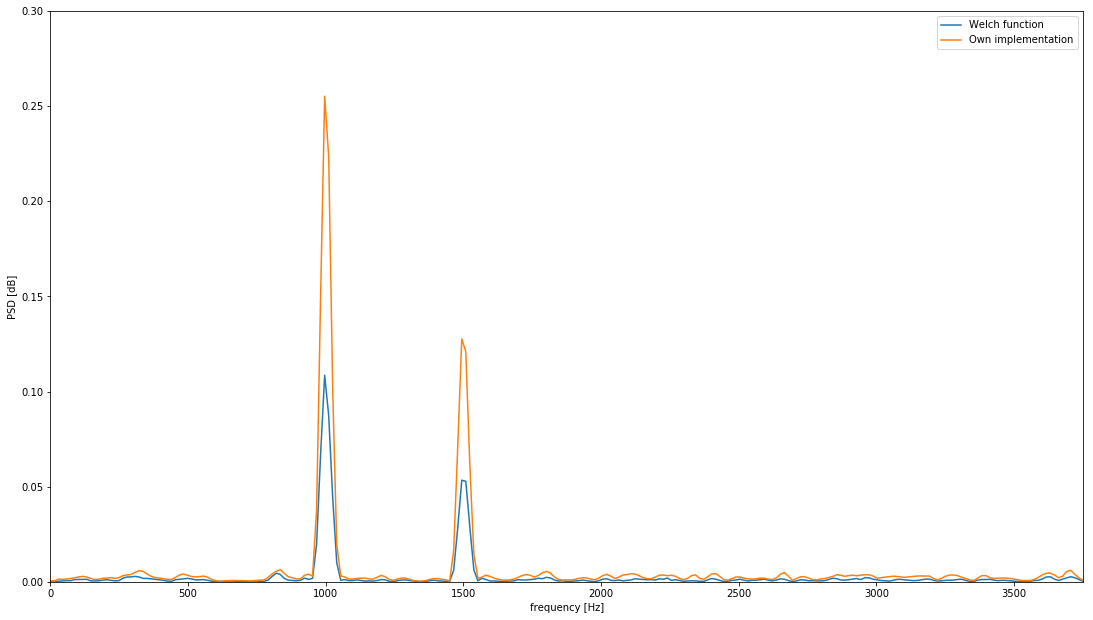

In [9]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(f, PSD_welch,label='Welch function')
plt.plot(freq,PSD_own,label='Own implementation')
plt.ylim([0,0.3])
plt.xlim([0, fs/2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [dB]')
plt.legend()